In [703]:
import numpy as np
import cv2
import math
from skimage.transform import rotate
import os
from multiprocessing.dummy import Pool as ThreadPool 
import shutil

def facial_lum(image):    
    exposure=1.2
    r2=np.random.rand()
    r3=np.random.rand()
    exposure = r2*(exposure - 1) + 1
    if(r3 > 0.5):
        exposure=1.0/exposure;
    img_hsv=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2]=cv2.multiply(img_hsv[:,:,2],exposure)
    img_rgb=cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB)
   # H,S,V=cv2.split(img_hsv)
    return cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY)

def coordinate_rotation(coordinates,center,angle):
    homogeneous_coordinates=np.concatenate([coordinates,np.ones((coordinates.shape[0],1))],axis=1)
    transtion_matrix1=np.matrix([[1,0,0],
                                [0,1,0],
                                [-center[0],-center[1],1]])
    rotation_matrix=np.matrix([[np.cos(angle),np.sin(angle),0],
                                [-np.sin(angle),np.cos(angle),0],
                                [0,0,1]])
    transtion_matrix2=np.matrix([[1,0,0],
                                [0,1,0],
                                [+center[0],+center[1],1]])
    new_coordinates=homogeneous_coordinates*transtion_matrix1*rotation_matrix*transtion_matrix2
    return new_coordinates[:,0:2]

def rotation_correction83(im,landmarks83):
    left_eye=np.mean(landmarks83[[26,19],:],axis=0)
    right_eye=np.mean(landmarks83[[72,65],:],axis=0)
    nose=landmarks83[64,:]
    left_mouth=landmarks83[37,:]
    right_mouth=landmarks83[46,:]
    eye_center=np.floor(1.0/2*(left_eye+right_eye));
    mouth_center=np.floor(1.0/2*(left_mouth+right_mouth));
    distance=lambda x,y:np.sqrt(np.sum(np.power(x-y,2)))
    eye_distance=distance(left_eye,right_eye)
    eye_mouth_distance=distance(eye_center,mouth_center)
    eye_nose_distance=distance(eye_center,nose);
    mouth_distance=distance(left_mouth,right_mouth);
    eye_alignment_vector=right_eye-left_eye
    angle_between_alignment_horizon=np.arctan(-1.0*eye_alignment_vector[1]/eye_alignment_vector[0])
    im=rotate(im,-angle_between_alignment_horizon/math.pi*180,center=eye_center)
    landmarks83_new=coordinate_rotation(landmarks83,eye_center,angle_between_alignment_horizon)
    return (im*255).astype(int),np.array(landmarks83_new)

def random_rotation(im,landmark83):
    left_eye=np.mean(landmark83[[26,19],:],axis=0)
    right_eye=np.mean(landmark83[[72,65],:],axis=0)
    eye_center=np.floor(1.0/2*(left_eye+right_eye));
    angle=np.random.randint(-20,21)
    im=rotate(im,angle,center=eye_center)
    degree=-angle*math.pi/180
    landmark=coordinate_rotation(landmark83,eye_center,degree)
    return im,np.array(landmark)

def landmark_reader(file_path):
    landmark=np.fromfile(file_path,sep=' ')[:-5]
    return landmark.reshape((-1,2))

def bbox_from_points(points):
#    mid_point=np.mean(points,axis=0)
    max_=np.max(points,axis=0)
    min_=np.min(points,axis=0)
#    r=np.max(max_-min_)/2
    return [min_[0],min_[1],max_[0],max_[1]]

def valid_bbox(w,h,bbox):
    bbox_new=[0,0,0,0]
    bbox_new[0]=np.clip(bbox[0],0,w-1)
    bbox_new[1]=np.clip(bbox[1],0,h-1)
    bbox_new[2]=np.clip(bbox[2],0,w-1)
    bbox_new[3]=np.clip(bbox[3],0,h-1)
    return bbox_new
def bbox_enlarging(bbox,img_shape,alpha):

    bbox_=[0,0,0,0]
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]   
    bbox_[0]=max(0,bbox[0]-alpha*width*10)
    bbox_[1]=max(0,bbox[1]-alpha*height)
    bbox_[2]=min(img_shape[1],bbox[2]-alpha*width*0.6)
    bbox_[3]=min(img_shape[0],bbox[3]+alpha*height)
    return bbox_

In [705]:
path='G:\\Calling_Dataset2\\Calling_Dataset_All'

In [706]:
import os
import shutil

In [707]:
img_paths=map(lambda x:os.path.join(path,x),filter(lambda x :'.jpg' in x,os.listdir(path)))

In [708]:
img_path

'G:\\Calling_Dataset2\\lm83_unsifted\\custom_141056f6a107417dafe6e57afa0a9eed-8_0_0_m0_l1_r0_e3_0.jpg'

In [709]:
import matplotlib.pyplot as plt

In [710]:
%matplotlib inline

In [711]:
import cv2

In [712]:
range(index_,index_+5)

[0, 1, 2, 3, 4]

In [718]:
def add_yaw_to_bbox(img_width,bbox,yaw,alpha):

    width=bbox[2]-bbox[0]+1
    angle=yaw*np.pi/180*0.25
    if angle>0:
        bbox[0]=max(0,bbox[0]-width*alpha*angle)
    if angle<0:
        bbox[2]=min(img_width,bbox[2]+width*alpha*angle)
    return bbox
index_=0
#plt.figure(figsize=(20,20))
for i,j in enumerate(range(len(img_paths))[9000:]):
    img_path=img_paths[j]
    lm_path=img_path.replace('.jpg','_83pts.txt')
    fname=os.path.basename(img_path)
    fn,ext=os.path.splitext(fname)
    #print lm_path
    img=cv2.imread(img_path)
    arr=np.fromfile(lm_path,sep=' ')
    alpha=10
    lm83=arr[:-5].reshape(-1,2)
    bbox=arr[-5:-1]
    yaw=arr[-2]
    img_new=img
    h,w,ch=img.shape
    lm83_new=lm83
    img_new,lm83_new=rotation_correction83(img,lm83)
    #img_new,lm83_new=random_rotation(copy.copy(img_new),copy.copy(lm83_new))
    bbox=bbox_from_points(lm83_new)
    face_w=bbox[2]-bbox[0]
    profile_bbox_w=face_w*0.25
    profile_bbox_h=(bbox[3]-bbox[1])/2
    profile_bbox_v=np.array([profile_bbox_w,profile_bbox_h])
    center_right=lm83_new[14,:]
    center_left=lm83_new[5,:]
    center_shift_right=np.array([center_right[0]+profile_bbox_w/2,center_right[1]])
    center_shift_left=np.array([center_left[0]-profile_bbox_w/2,center_left[1]])
    profile_bbox_right=valid_bbox(w,h,np.concatenate([center_shift_right-profile_bbox_v,center_shift_right+profile_bbox_v]).astype(int))
    profile_bbox_left=valid_bbox(w,h,np.concatenate([center_shift_left-profile_bbox_v,center_shift_left+profile_bbox_v]).astype(int))
    #profile_bbox_right=add_yaw_to_bbox(img.shape[1],profile_bbox_right,yaw,alpha)
    #profile_bbox_left=add_yaw_to_bbox(img.shape[1],profile_bbox_left,yaw,alpha)
    #plt.subplot(5,3,3*i+1)
    left=copy.copy(cv2.flip(img_new[profile_bbox_left[1]:profile_bbox_left[3],profile_bbox_left[0]:profile_bbox_left[2]],1))
    #plt.imshow(left)
    #plt.subplot(5,3,3*i+2)
    right=copy.copy(img_new[profile_bbox_right[1]:profile_bbox_right[3],profile_bbox_right[0]:profile_bbox_right[2]])
    #plt.subplot(5,3,3*i+3)
    #show_all(img_new,np.array(profile_bbox_left).reshape(-1,2))
    #show_all(img_new,lm83_new)
    #print profile_bbox_left,profile_bbox_right
    cv2.imwrite(os.path.join('G:\\Calling_Dataset2\\unsifted_profile',fn+'_left'+ext),left)
    cv2.imwrite(os.path.join('G:\\Calling_Dataset2\\unsifted_profile',fn+'_right'+ext),right)

KeyboardInterrupt: 

In [612]:
def show_all(img,lm83,flag=True):
    if flag==True:
        plt.imshow(img)
    plt.scatter(lm83[:,0],lm83[:,1])
    for i in range(lm83.shape[0]):
        plt.text(lm83[i,0],lm83[i,1],s=str(i))

## Left Face

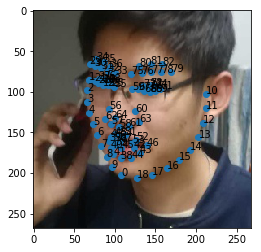

In [613]:
show_all(img_new,lm83_new)

In [617]:
lm83_new[[5],:]

array([[  73.,  140.]])

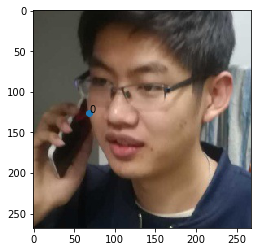

In [618]:
show_all(img_new,lm83_new[[4],:])

In [616]:
center_right=lm83_new[14,:]
center_left=lm83_new[5,:]

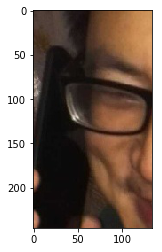

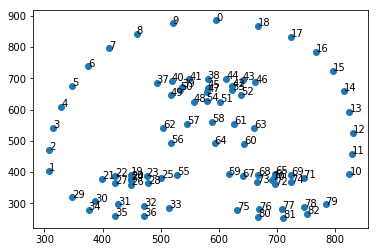

In [561]:
#plt.imshow(img)
plt.scatter(lm83[:,0],lm83[:,1])
for i in range(83):
    plt.text(lm83[i,0],lm83[i,1],s=str(i))

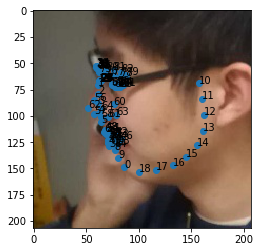

In [567]:
plt.imshow(img)
plt.scatter(lm83[:,0],lm83[:,1])
for i in range(83):
    plt.text(lm83[i,0],lm83[i,1],s=str(i))

In [443]:
img_new,lm83_new=rotation_correction83(img,lm83)

In [444]:
# #plt.imshow(img_new)
# plt.scatter(lm83_new[:,0],lm83_new[:,1])
# for i in range(83):
#     plt.text(lm83_new[i,0],lm83_new[i,1],s=str(i))

In [445]:
face_w=lm83_new[10,0]-lm83_new[1,0]

In [171]:
profile_bbox_v

array([ 44.28729459,  60.09842959])

In [173]:
profile_bbox

array([365, 328, 454, 448])

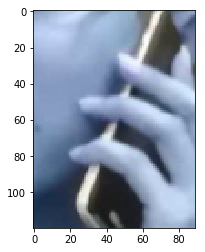

In [ ]:
face_w=bbox[2]-bbox[0]
profile_bbox_w=face_w*0.25
profile_bbox_h=(bbox[3]-bbox[1])/2
profile_bbox_v=np.array([profile_bbox_w,profile_bbox_h])
center_right=lm83_new[14,:]
center_left=lm83_new[5,:]
center_shift_right=np.array([center_right[0]+profile_bbox_w/2,center_right[1]-profile_bbox_h/2])
center_shift_left=np.array([center_left[0]+profile_bbox_w/2,center_left[1]-profile_bbox_h/2])
profile_bbox_right=np.concatenate([center_shift_right-profile_bbox_v,center_shift_right+profile_bbox_v]).astype(int)
profile_bbox_left=np.concatenate([center_shift_left-profile_bbox_v,center_shift_left+profile_bbox_v]).astype(int)

In [ ]:
center_shift_right=np.array([center_right[0]+profile_bbox_w/2,center_right[1]])
center_shift_left=np.array([center_left[0]-profile_bbox_w/2,center_left[1]])
profile_bbox_right=np.concatenate([center_shift_right-profile_bbox_v,center_shift_right+profile_bbox_v]).astype(int)
profile_bbox_left=np.concatenate([center_shift_left-profile_bbox_v,center_shift_left+profile_bbox_v]).astype(int)

In [ ]:

plt.subplot(1,2,1)
plt.imshow(img_new[profile_bbox_left[1]:profile_bbox_left[3],profile_bbox_left[0]:profile_bbox_left[2]])
plt.subplot(1,2,2)

plt.imshow(img_new[profile_bbox_right[1]:profile_bbox_right[3],profile_bbox_right[0]:profile_bbox_right[2]])